In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm

## Adaptive Network

In [2]:
def adaptive_SIS(net, beta, mu, n_iter, initial_infected, w, tol=1e-5):
    """
    Simulate the adaptive SIS model on a graph.

    Parameters
    ----------
    G : nx.Graph
        The graph on which to simulate the model.
    beta : float
        The infection rate.
    mu : float
        The recovery rate.
    n_iter : int
        The number of time steps to simulate.
    initial_infected : int
        The number of initial infected nodes.
    w: float
        Probability of rewiring
    
    Returns
    -------
    i : list
        The number of infected nodes once converged.
    """
    G = net.copy()
    # Initialize the state of the nodes
    N = G.number_of_nodes()
    nx.set_node_attributes(G, 0, 'state')
    # Infect the initial infected nodes at random
    infected = np.random.choice(G.nodes, initial_infected, replace=False)
    for i in infected:
        G.nodes[i]['state'] = 1

    # Simulate the model
    i_vec = np.array([])
    for t in range(n_iter):
        # # check the number of self loops and multiple edges
        # print('Number of self loops: ', nx.number_of_selfloops(G))
        # print('Number of multiple edges: ', G.number_of_edges())

        # Update topology

        # For each node
        for i in G.nodes:
            # If the node is susceptible
            if G.nodes[i]['state'] == 0:
                # get the neighbors of the node
                neighbors = list(G.neighbors(i))
                # count the number of infected neighbors
                n_infected = np.sum([G.nodes[neighbor]['state'] for neighbor in neighbors])
                if n_infected > 0:
                    # change the edge to a random susceptible node with probability w
                    edge_to_change = np.array([])
                    for neighbor in neighbors:
                        if G.nodes[neighbor]['state'] == 1: 
                            if np.random.rand() < w:
                                edge_to_change = np.append(edge_to_change, neighbor)
                    # change the edge 
                    for neighbor in edge_to_change:
                        # if there exists a susceptible node different from the neighbors of i and the node i
                        if len([j for j in G.nodes if G.nodes[j]['state'] == 0 and j not in neighbors and j != i]) > 0:
                            # choose a random susceptible node
                            new_neighbor = np.random.choice([j for j in G.nodes if G.nodes[j]['state'] == 0 and j not in neighbors and j != i])
                            # remove the edge between i and neighbor
                            G.remove_edge(i, neighbor)
                            # add the edge between i and new_neighbor
                            G.add_edge(i, new_neighbor)

        # Update the state of the nodes (at the end of the loop over the nodes)

        new_states = {}                       
        for i in G.nodes:
            if G.nodes[i]['state'] == 0:
                for j in G.neighbors(i):
                    if G.nodes[j]['state'] == 1:
                        if np.random.rand() < beta:
                            new_states[i] = 1
                            break
            # If the node is infected
            else:
                if np.random.rand() < mu:
                    new_states[i] = 0
        # update the state of the nodes
        for i, s in new_states.items():
            G.nodes[i]['state'] = s

        i_vec = np.append(i_vec, sum([G.nodes[i]['state'] for i in G.nodes])/N)
        # stop if the number of infected nodes is 0
        if np.isclose(sum([G.nodes[i]['state'] for i in G.nodes]), 0):
            break
        # stop if the number of infected nodes is N
        if np.isclose(sum([G.nodes[i]['state'] for i in G.nodes]), N):
            break
        # stop if the variance of the last 10 iterations is less than 0.01
        if t > 50:
            if np.var(i_vec[-50:]) < tol:
                break
        
    # print('Number of infected nodes: ', sum([G.nodes[i]['state']/N for i in G.nodes]))
    # Count the number of infected nodes at the end of the simulation
    i = sum([G.nodes[i]['state'] for i in G.nodes])/N
    print('Fraction of infected nodes: ', i, '; Initial infected nodes: ', initial_infected, '; Number of iterations: ', t)
    return i


def RK4(x0, h, Tmax, f, **kwargs):
    """
    Runge-Kutta 4 method

    Parameters
    ----------
    x0 : array
        initial values
    h : float
        step size
    Tmax : float
        maximum time
    f : function
        function to be integrated
    """
    x = np.array([x0])
    t = np.array([0])
    while t[-1] < Tmax:
        k1 = h*f(x[-1], **kwargs)
        k2 = h*f(x[-1] + k1/2, **kwargs)
        k3 = h*f(x[-1] + k2/2, **kwargs)
        k4 = h*f(x[-1] + k3, **kwargs)
        x = np.append(x, [x[-1] + (k1 + 2*k2 + 2*k3 + k4)/6], axis=0)
        t = np.append(t, t[-1] + h)
    return x, t

def adaptive_mf(x, param_list, mean_degree):
    """
    Parameters
    ----------
    x : array
        array of values (i, l_ii, l_ss)
    param_list : list
        list of parameters (beta, mu, w)
    
    Returns 
    ------- 
    array
        array of derivatives
    """
    beta, mu, w = param_list[0], param_list[1], param_list[2]

    i, l_ii, l_ss = x[0], x[1], x[2]
    s = 1 - i
    l_si = mean_degree/2 - l_ii - l_ss

    di = -mu*i + beta*l_si
    dl_ii = -2*mu*l_ii + beta*l_si*(l_si/s + 1)
    dl_ss = -2*beta*l_si*l_ss/s + (mu+w)*l_si
    return np.array([di, dl_ii, dl_ss])

def critical_beta(mu, w, mean_degree):
    """
    Parameters
    ----------
    mu : float
        recovery rate
    w : float
        probability of rewiring
    mean_degree : float
        mean degree of the network
    
    Returns
    -------
    float
        critical beta
    """
    if w == 0:
        return mu/mean_degree
    else:
        return w/(mean_degree*(1-np.exp(-w/mu)))
    
def make_analytical_graph(N, p, mu, beta_list, w, m_low, m_high, h, Tmax):
    """
    
    Parameters
    ----------
    N : int
        number of nodes
    p : float
        probability of connection
    mu : float
        recovery rate
    beta_list : list
        list of beta values
    w : float
        probability of rewiring
    m_low : int
        low number of initial infected nodes
    m_high : int
        high number of initial infected nodes
    h : float
        step size
    Tmax : float
        maximum time

    Returns
    -------
    fig : matplotlib.figure.Figure
        figure of the plot
    """

    mean_degree = p*(N-1)

    # initial conditions
    i = m_low/N
    l_ii = (i**2)*mean_degree/2
    l_ss = ((1-i)**2)*mean_degree/2
    initial_conditions_low = [i, l_ii, l_ss]

    i = m_high/N
    l_ii = (i**2)*mean_degree/2
    l_ss = ((1-i)**2)*mean_degree/2
    initial_conditions_high = [i, l_ii, l_ss]


    i_low_list = np.array([])
    i_high_list = np.array([])
    for b in tqdm(beta_list):
        x_low, _ = RK4(initial_conditions_low, h, Tmax, adaptive_mf, param_list=[b, mu, w], mean_degree=mean_degree)
        i_low_list = np.append(i_low_list, x_low[-1, 0])
        x_high, _ = RK4(initial_conditions_high, h, Tmax, adaptive_mf, param_list=[b, mu, w], mean_degree=mean_degree)
        i_high_list = np.append(i_high_list, x_high[-1, 0])

    
    print('p*(w=0)', mu/mean_degree)
    print('p*(w)', w/(mean_degree*(1-np.exp(-w/mu))))

    plt.figure(figsize=(10, 7))
    plt.title(f'Rewiring probability w = {w}', fontsize=15)
    plt.plot(beta_list, i_low_list, label=r'$i_0 = 0.01$')
    plt.plot(beta_list, i_high_list, label=r'$i_0 = 0.9$', alpha=0.7)
    plt.xlabel(r'$\beta$', fontsize=15)
    plt.ylabel('i*', fontsize=15) 
    plt.grid()
    plt.vlines(critical_beta(mu, w, mean_degree), -1, 2, color='black', linestyle='--', alpha=0.5, label=r'$\beta_c(w)$')
    plt.ylim(-0.05, 1.05)
    plt.legend(fontsize=15)
    plt.show()

#### Numerical solution

100%|██████████| 50/50 [00:02<00:00, 24.89it/s]
/var/folders/lx/thnwywfs79x9xsl2bq8yrjy00000gn/T/ipykernel_28817/1366087031.py:232: RuntimeWarning: invalid value encountered in scalar divide
  print('p*(w)', w/(mean_degree*(1-np.exp(-w/mu))))


p*(w=0) 0.001001001001001001
p*(w) nan


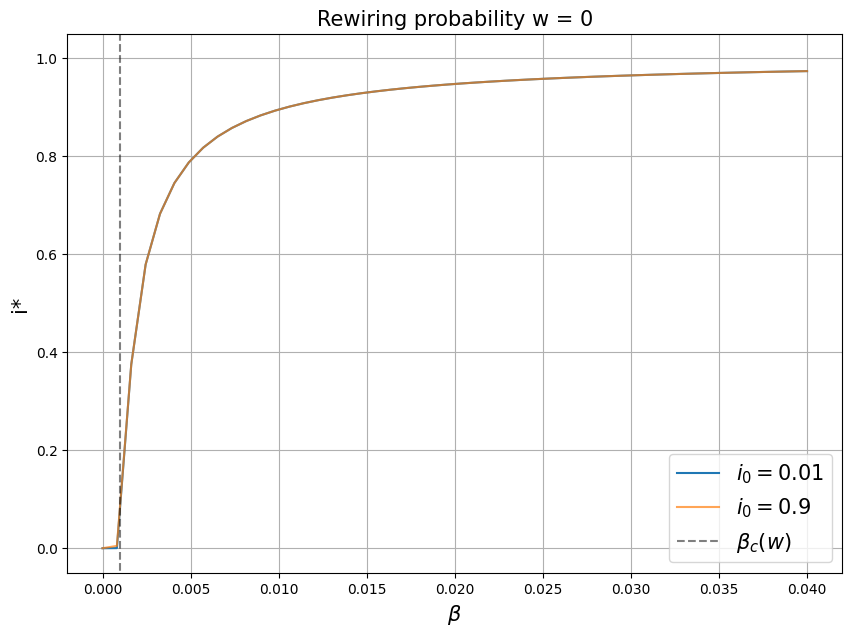

100%|██████████| 50/50 [00:01<00:00, 25.31it/s]


p*(w=0) 0.001001001001001001
p*(w) 0.010010464484394492


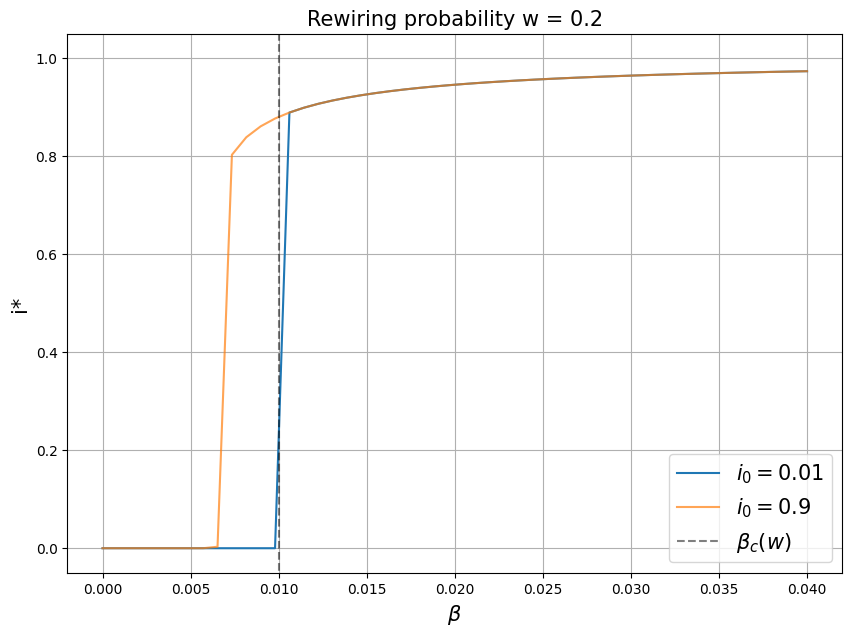

100%|██████████| 50/50 [00:01<00:00, 25.34it/s]


p*(w=0) 0.001001001001001001
p*(w) 0.02502502502537257


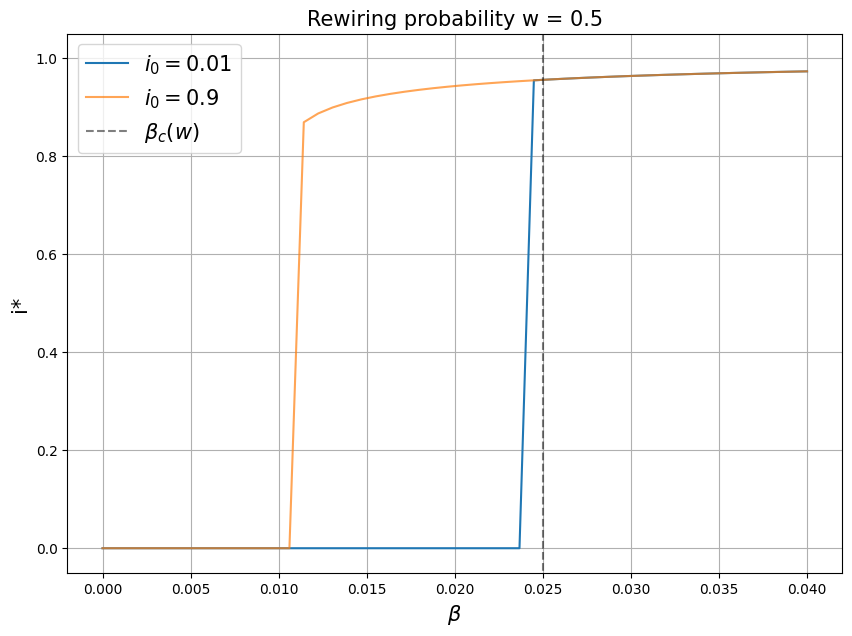

In [3]:
# network
N = 10**3
p = 0.02

# epidemic parameters
mu = 0.02
beta_list = np.linspace(0, 0.04, 50)
w_list = [0, 0.2, 0.5]

# initial conditions
m_low = 10
m_high = 900

# RG parameters
h = 1
Tmax = 1000

for w in w_list:
    make_analytical_graph(N, p, mu, beta_list, w, m_low, m_high, h, Tmax)

#### Numerical simulation

In [4]:
def make_numerical_graph(G, mu, beta_list, w, m_low, m_high, n_iter, tol):
    # Simulate the model and plot the results for different values of beta
    i_list_low = np.array([])
    i_list_high = np.array([])
    for beta in tqdm(beta_list):
        #print('beta: ', beta)
        i_low = adaptive_SIS(G, beta, mu, n_iter, m_low, w, tol)
        i_high = adaptive_SIS(G, beta, mu, n_iter, m_high, w, tol)
        i_list_low = np.append(i_list_low, i_low)
        i_list_high = np.append(i_list_high, i_high)

    plt.figure(figsize=(10, 7))
    plt.plot(beta_list, i_list_low, 'o', label=r'$i_0 = 0.01$')
    plt.plot(beta_list, i_list_high, '.', color='red', label=r'$i_0 = 0.9$')
    plt.xlabel(r'$\beta$', fontsize=15)
    plt.title(f'Rewiring probability w = {w}', fontsize=15)
    plt.ylabel('i*', fontsize=15)
    plt.grid()
    plt.legend(fontsize=15)
    plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

Fraction of infected nodes:  0.002 ; Initial infected nodes:  10 ; Number of iterations:  51


  2%|▏         | 1/50 [00:03<02:44,  3.35s/it]

Fraction of infected nodes:  0.01 ; Initial infected nodes:  900 ; Number of iterations:  243
Fraction of infected nodes:  0.009 ; Initial infected nodes:  10 ; Number of iterations:  51


  4%|▍         | 2/50 [00:07<03:16,  4.10s/it]

Fraction of infected nodes:  0.054 ; Initial infected nodes:  900 ; Number of iterations:  354
Fraction of infected nodes:  0.362 ; Initial infected nodes:  10 ; Number of iterations:  499


  6%|▌         | 3/50 [00:19<05:47,  7.39s/it]

Fraction of infected nodes:  0.393 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.557 ; Initial infected nodes:  10 ; Number of iterations:  499


  8%|▊         | 4/50 [00:28<06:21,  8.29s/it]

Fraction of infected nodes:  0.577 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.691 ; Initial infected nodes:  10 ; Number of iterations:  499


 10%|█         | 5/50 [00:36<05:58,  7.97s/it]

Fraction of infected nodes:  0.637 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.742 ; Initial infected nodes:  10 ; Number of iterations:  499


 12%|█▏        | 6/50 [00:42<05:27,  7.43s/it]

Fraction of infected nodes:  0.726 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.784 ; Initial infected nodes:  10 ; Number of iterations:  499


 14%|█▍        | 7/50 [00:48<04:58,  6.94s/it]

Fraction of infected nodes:  0.789 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.79 ; Initial infected nodes:  10 ; Number of iterations:  499


 16%|█▌        | 8/50 [00:53<04:24,  6.31s/it]

Fraction of infected nodes:  0.794 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.857 ; Initial infected nodes:  10 ; Number of iterations:  499
Fraction of infected nodes:  0.849 ; Initial infected nodes:  900 ; Number of iterations:  499


 18%|█▊        | 9/50 [00:58<03:55,  5.74s/it]

Fraction of infected nodes:  0.853 ; Initial infected nodes:  10 ; Number of iterations:  499
Fraction of infected nodes:  0.845 ; Initial infected nodes:  900 ; Number of iterations:  499


 22%|██▏       | 11/50 [01:06<03:09,  4.85s/it]

Fraction of infected nodes:  0.855 ; Initial infected nodes:  10 ; Number of iterations:  499
Fraction of infected nodes:  0.877 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.88 ; Initial infected nodes:  10 ; Number of iterations:  499
Fraction of infected nodes:  0.889 ; Initial infected nodes:  900 ; Number of iterations:  499


 24%|██▍       | 12/50 [01:09<02:50,  4.49s/it]

Fraction of infected nodes:  0.896 ; Initial infected nodes:  10 ; Number of iterations:  499
Fraction of infected nodes:  0.875 ; Initial infected nodes:  900 ; Number of iterations:  499


 28%|██▊       | 14/50 [01:16<02:19,  3.87s/it]

Fraction of infected nodes:  0.885 ; Initial infected nodes:  10 ; Number of iterations:  499
Fraction of infected nodes:  0.886 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.898 ; Initial infected nodes:  10 ; Number of iterations:  499
Fraction of infected nodes:  0.904 ; Initial infected nodes:  900 ; Number of iterations:  499


 30%|███       | 15/50 [01:19<02:06,  3.63s/it]

Fraction of infected nodes:  0.899 ; Initial infected nodes:  10 ; Number of iterations:  499
Fraction of infected nodes:  0.901 ; Initial infected nodes:  900 ; Number of iterations:  499


 34%|███▍      | 17/50 [01:25<01:47,  3.25s/it]

Fraction of infected nodes:  0.91 ; Initial infected nodes:  10 ; Number of iterations:  499
Fraction of infected nodes:  0.907 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.917 ; Initial infected nodes:  10 ; Number of iterations:  499


 36%|███▌      | 18/50 [01:28<01:39,  3.11s/it]

Fraction of infected nodes:  0.917 ; Initial infected nodes:  900 ; Number of iterations:  499


 38%|███▊      | 19/50 [01:30<01:31,  2.96s/it]

Fraction of infected nodes:  0.913 ; Initial infected nodes:  10 ; Number of iterations:  499
Fraction of infected nodes:  0.928 ; Initial infected nodes:  900 ; Number of iterations:  499


 40%|████      | 20/50 [01:33<01:25,  2.84s/it]

Fraction of infected nodes:  0.931 ; Initial infected nodes:  10 ; Number of iterations:  499
Fraction of infected nodes:  0.926 ; Initial infected nodes:  900 ; Number of iterations:  499


 42%|████▏     | 21/50 [01:35<01:19,  2.74s/it]

Fraction of infected nodes:  0.937 ; Initial infected nodes:  10 ; Number of iterations:  499
Fraction of infected nodes:  0.934 ; Initial infected nodes:  900 ; Number of iterations:  499


 44%|████▍     | 22/50 [01:38<01:14,  2.66s/it]

Fraction of infected nodes:  0.941 ; Initial infected nodes:  10 ; Number of iterations:  499
Fraction of infected nodes:  0.93 ; Initial infected nodes:  900 ; Number of iterations:  499


 46%|████▌     | 23/50 [01:40<01:09,  2.59s/it]

Fraction of infected nodes:  0.939 ; Initial infected nodes:  10 ; Number of iterations:  499
Fraction of infected nodes:  0.934 ; Initial infected nodes:  900 ; Number of iterations:  499


 48%|████▊     | 24/50 [01:43<01:05,  2.53s/it]

Fraction of infected nodes:  0.92 ; Initial infected nodes:  10 ; Number of iterations:  499
Fraction of infected nodes:  0.937 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.931 ; Initial infected nodes:  10 ; Number of iterations:  499


 50%|█████     | 25/50 [01:46<01:06,  2.65s/it]

Fraction of infected nodes:  0.939 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.936 ; Initial infected nodes:  10 ; Number of iterations:  499


 52%|█████▏    | 26/50 [01:48<01:00,  2.54s/it]

Fraction of infected nodes:  0.948 ; Initial infected nodes:  900 ; Number of iterations:  499


 54%|█████▍    | 27/50 [01:50<00:57,  2.49s/it]

Fraction of infected nodes:  0.936 ; Initial infected nodes:  10 ; Number of iterations:  499
Fraction of infected nodes:  0.947 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.952 ; Initial infected nodes:  10 ; Number of iterations:  499


 56%|█████▌    | 28/50 [01:53<00:53,  2.45s/it]

Fraction of infected nodes:  0.94 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.933 ; Initial infected nodes:  10 ; Number of iterations:  499


 58%|█████▊    | 29/50 [01:55<00:51,  2.44s/it]

Fraction of infected nodes:  0.934 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.944 ; Initial infected nodes:  10 ; Number of iterations:  499
Fraction of infected nodes:  0.94 ; Initial infected nodes:  900 ; Number of iterations:  499


 60%|██████    | 30/50 [01:57<00:48,  2.43s/it]

Fraction of infected nodes:  0.958 ; Initial infected nodes:  10 ; Number of iterations:  499
Fraction of infected nodes:  0.942 ; Initial infected nodes:  900 ; Number of iterations:  499


 62%|██████▏   | 31/50 [02:00<00:45,  2.39s/it]

Fraction of infected nodes:  0.951 ; Initial infected nodes:  10 ; Number of iterations:  499


 64%|██████▍   | 32/50 [02:02<00:43,  2.42s/it]

Fraction of infected nodes:  0.955 ; Initial infected nodes:  900 ; Number of iterations:  499


 66%|██████▌   | 33/50 [02:04<00:39,  2.31s/it]

Fraction of infected nodes:  0.955 ; Initial infected nodes:  10 ; Number of iterations:  499
Fraction of infected nodes:  0.96 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.959 ; Initial infected nodes:  10 ; Number of iterations:  499


 68%|██████▊   | 34/50 [02:06<00:35,  2.21s/it]

Fraction of infected nodes:  0.931 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.959 ; Initial infected nodes:  10 ; Number of iterations:  499


 70%|███████   | 35/50 [02:08<00:32,  2.14s/it]

Fraction of infected nodes:  0.955 ; Initial infected nodes:  900 ; Number of iterations:  499


 72%|███████▏  | 36/50 [02:10<00:29,  2.10s/it]

Fraction of infected nodes:  0.958 ; Initial infected nodes:  10 ; Number of iterations:  499
Fraction of infected nodes:  0.948 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.96 ; Initial infected nodes:  10 ; Number of iterations:  499


 74%|███████▍  | 37/50 [02:12<00:26,  2.06s/it]

Fraction of infected nodes:  0.947 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.948 ; Initial infected nodes:  10 ; Number of iterations:  499


 76%|███████▌  | 38/50 [02:14<00:24,  2.01s/it]

Fraction of infected nodes:  0.97 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.948 ; Initial infected nodes:  10 ; Number of iterations:  499


 78%|███████▊  | 39/50 [02:16<00:21,  1.96s/it]

Fraction of infected nodes:  0.961 ; Initial infected nodes:  900 ; Number of iterations:  499


 80%|████████  | 40/50 [02:18<00:19,  1.92s/it]

Fraction of infected nodes:  0.969 ; Initial infected nodes:  10 ; Number of iterations:  499
Fraction of infected nodes:  0.967 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.944 ; Initial infected nodes:  10 ; Number of iterations:  499


 82%|████████▏ | 41/50 [02:20<00:17,  1.90s/it]

Fraction of infected nodes:  0.967 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.965 ; Initial infected nodes:  10 ; Number of iterations:  499


 84%|████████▍ | 42/50 [02:21<00:15,  1.89s/it]

Fraction of infected nodes:  0.96 ; Initial infected nodes:  900 ; Number of iterations:  499


 86%|████████▌ | 43/50 [02:23<00:13,  1.87s/it]

Fraction of infected nodes:  0.962 ; Initial infected nodes:  10 ; Number of iterations:  499
Fraction of infected nodes:  0.958 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.957 ; Initial infected nodes:  10 ; Number of iterations:  499


 88%|████████▊ | 44/50 [02:25<00:11,  1.85s/it]

Fraction of infected nodes:  0.959 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.961 ; Initial infected nodes:  10 ; Number of iterations:  499


 90%|█████████ | 45/50 [02:27<00:09,  1.82s/it]

Fraction of infected nodes:  0.957 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.965 ; Initial infected nodes:  10 ; Number of iterations:  499
Fraction of infected nodes:  0.962 ; Initial infected nodes:  900 ; Number of iterations:  499


 92%|█████████▏| 46/50 [02:29<00:07,  1.93s/it]

Fraction of infected nodes:  0.969 ; Initial infected nodes:  10 ; Number of iterations:  499
Fraction of infected nodes:  0.956 ; Initial infected nodes:  900 ; Number of iterations:  499


 94%|█████████▍| 47/50 [02:31<00:05,  1.88s/it]

Fraction of infected nodes:  0.962 ; Initial infected nodes:  10 ; Number of iterations:  499
Fraction of infected nodes:  0.965 ; Initial infected nodes:  900 ; Number of iterations:  499


 98%|█████████▊| 49/50 [02:34<00:01,  1.79s/it]

Fraction of infected nodes:  0.97 ; Initial infected nodes:  10 ; Number of iterations:  499
Fraction of infected nodes:  0.964 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.971 ; Initial infected nodes:  10 ; Number of iterations:  499


100%|██████████| 50/50 [02:36<00:00,  3.13s/it]

Fraction of infected nodes:  0.972 ; Initial infected nodes:  900 ; Number of iterations:  499


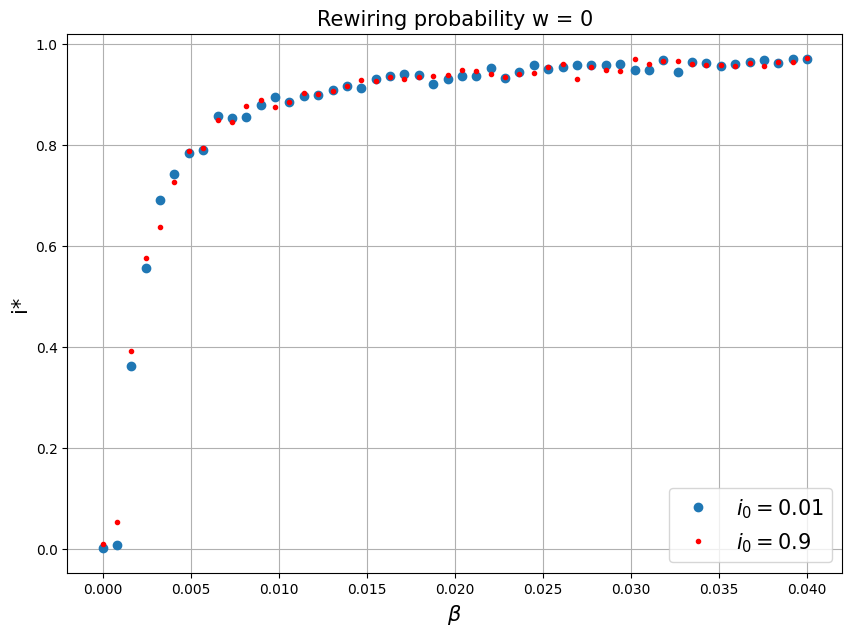

  0%|          | 0/50 [00:00<?, ?it/s]

Fraction of infected nodes:  0.003 ; Initial infected nodes:  10 ; Number of iterations:  51


  2%|▏         | 1/50 [00:07<05:43,  7.00s/it]

Fraction of infected nodes:  0.008 ; Initial infected nodes:  900 ; Number of iterations:  239
Fraction of infected nodes:  0.002 ; Initial infected nodes:  10 ; Number of iterations:  51


  4%|▍         | 2/50 [00:14<05:42,  7.13s/it]

Fraction of infected nodes:  0.007 ; Initial infected nodes:  900 ; Number of iterations:  243
Fraction of infected nodes:  0.003 ; Initial infected nodes:  10 ; Number of iterations:  51


  6%|▌         | 3/50 [00:21<05:47,  7.39s/it]

Fraction of infected nodes:  0.005 ; Initial infected nodes:  900 ; Number of iterations:  243
Fraction of infected nodes:  0.005 ; Initial infected nodes:  10 ; Number of iterations:  51


  8%|▊         | 4/50 [00:29<05:43,  7.46s/it]

Fraction of infected nodes:  0.011 ; Initial infected nodes:  900 ; Number of iterations:  231
Fraction of infected nodes:  0.005 ; Initial infected nodes:  10 ; Number of iterations:  51


 10%|█         | 5/50 [00:38<06:01,  8.04s/it]

Fraction of infected nodes:  0.006 ; Initial infected nodes:  900 ; Number of iterations:  283
Fraction of infected nodes:  0.009 ; Initial infected nodes:  10 ; Number of iterations:  51


 12%|█▏        | 6/50 [00:48<06:29,  8.85s/it]

Fraction of infected nodes:  0.004 ; Initial infected nodes:  900 ; Number of iterations:  284
Fraction of infected nodes:  0.007 ; Initial infected nodes:  10 ; Number of iterations:  51


 14%|█▍        | 7/50 [01:02<07:23, 10.30s/it]

Fraction of infected nodes:  0.006 ; Initial infected nodes:  900 ; Number of iterations:  273
Fraction of infected nodes:  0.008 ; Initial infected nodes:  10 ; Number of iterations:  51


 16%|█▌        | 8/50 [01:26<10:21, 14.80s/it]

Fraction of infected nodes:  0.007 ; Initial infected nodes:  900 ; Number of iterations:  312
Fraction of infected nodes:  0.005 ; Initial infected nodes:  10 ; Number of iterations:  51


 18%|█▊        | 9/50 [02:02<14:39, 21.46s/it]

Fraction of infected nodes:  0.002 ; Initial infected nodes:  900 ; Number of iterations:  376
Fraction of infected nodes:  0.003 ; Initial infected nodes:  10 ; Number of iterations:  51


 20%|██        | 10/50 [04:42<42:51, 64.28s/it]

Fraction of infected nodes:  0.595 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.012 ; Initial infected nodes:  10 ; Number of iterations:  82


 22%|██▏       | 11/50 [07:04<57:07, 87.89s/it]

Fraction of infected nodes:  0.731 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.003 ; Initial infected nodes:  10 ; Number of iterations:  90


 24%|██▍       | 12/50 [09:10<1:03:01, 99.51s/it]

Fraction of infected nodes:  0.711 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.006 ; Initial infected nodes:  10 ; Number of iterations:  51


 26%|██▌       | 13/50 [11:05<1:04:15, 104.19s/it]

Fraction of infected nodes:  0.75 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.007 ; Initial infected nodes:  10 ; Number of iterations:  51


 28%|██▊       | 14/50 [12:47<1:02:05, 103.47s/it]

Fraction of infected nodes:  0.754 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.012 ; Initial infected nodes:  10 ; Number of iterations:  84


 30%|███       | 15/50 [14:26<59:35, 102.17s/it]  

Fraction of infected nodes:  0.787 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.002 ; Initial infected nodes:  10 ; Number of iterations:  87


 32%|███▏      | 16/50 [15:52<55:06, 97.26s/it] 

Fraction of infected nodes:  0.801 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.008 ; Initial infected nodes:  10 ; Number of iterations:  51


 34%|███▍      | 17/50 [17:10<50:16, 91.42s/it]

Fraction of infected nodes:  0.851 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.874 ; Initial infected nodes:  10 ; Number of iterations:  499


 36%|███▌      | 18/50 [19:44<58:52, 110.38s/it]

Fraction of infected nodes:  0.851 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.855 ; Initial infected nodes:  10 ; Number of iterations:  499


 38%|███▊      | 19/50 [22:03<1:01:30, 119.04s/it]

Fraction of infected nodes:  0.853 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.868 ; Initial infected nodes:  10 ; Number of iterations:  499


 40%|████      | 20/50 [24:20<1:02:08, 124.30s/it]

Fraction of infected nodes:  0.861 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.874 ; Initial infected nodes:  10 ; Number of iterations:  499


 42%|████▏     | 21/50 [26:24<1:00:01, 124.17s/it]

Fraction of infected nodes:  0.829 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.882 ; Initial infected nodes:  10 ; Number of iterations:  499


 44%|████▍     | 22/50 [28:27<57:53, 124.04s/it]  

Fraction of infected nodes:  0.866 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.864 ; Initial infected nodes:  10 ; Number of iterations:  499


 46%|████▌     | 23/50 [30:24<54:48, 121.79s/it]

Fraction of infected nodes:  0.879 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.88 ; Initial infected nodes:  10 ; Number of iterations:  499


 48%|████▊     | 24/50 [32:15<51:23, 118.61s/it]

Fraction of infected nodes:  0.874 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.891 ; Initial infected nodes:  10 ; Number of iterations:  499


 50%|█████     | 25/50 [34:00<47:41, 114.46s/it]

Fraction of infected nodes:  0.9 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.906 ; Initial infected nodes:  10 ; Number of iterations:  499


 52%|█████▏    | 26/50 [35:41<44:11, 110.48s/it]

Fraction of infected nodes:  0.887 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.889 ; Initial infected nodes:  10 ; Number of iterations:  499


 54%|█████▍    | 27/50 [37:20<41:02, 107.08s/it]

Fraction of infected nodes:  0.895 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.914 ; Initial infected nodes:  10 ; Number of iterations:  499


 56%|█████▌    | 28/50 [39:00<38:26, 104.86s/it]

Fraction of infected nodes:  0.879 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.893 ; Initial infected nodes:  10 ; Number of iterations:  499


 58%|█████▊    | 29/50 [40:29<35:02, 100.13s/it]

Fraction of infected nodes:  0.897 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.906 ; Initial infected nodes:  10 ; Number of iterations:  499


 60%|██████    | 30/50 [41:57<32:09, 96.47s/it] 

Fraction of infected nodes:  0.907 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.919 ; Initial infected nodes:  10 ; Number of iterations:  499


 62%|██████▏   | 31/50 [43:23<29:32, 93.27s/it]

Fraction of infected nodes:  0.927 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.904 ; Initial infected nodes:  10 ; Number of iterations:  499


 64%|██████▍   | 32/50 [44:49<27:19, 91.10s/it]

Fraction of infected nodes:  0.907 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.913 ; Initial infected nodes:  10 ; Number of iterations:  499


 66%|██████▌   | 33/50 [46:10<24:57, 88.09s/it]

Fraction of infected nodes:  0.915 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.915 ; Initial infected nodes:  10 ; Number of iterations:  499


 68%|██████▊   | 34/50 [47:29<22:45, 85.33s/it]

Fraction of infected nodes:  0.924 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.91 ; Initial infected nodes:  10 ; Number of iterations:  499


 70%|███████   | 35/50 [48:43<20:30, 82.00s/it]

Fraction of infected nodes:  0.925 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.935 ; Initial infected nodes:  10 ; Number of iterations:  499


 72%|███████▏  | 36/50 [49:57<18:34, 79.58s/it]

Fraction of infected nodes:  0.922 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.937 ; Initial infected nodes:  10 ; Number of iterations:  499


 74%|███████▍  | 37/50 [51:08<16:39, 76.88s/it]

Fraction of infected nodes:  0.917 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.919 ; Initial infected nodes:  10 ; Number of iterations:  499


 76%|███████▌  | 38/50 [52:17<14:56, 74.71s/it]

Fraction of infected nodes:  0.916 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.921 ; Initial infected nodes:  10 ; Number of iterations:  499


 78%|███████▊  | 39/50 [53:29<13:31, 73.76s/it]

Fraction of infected nodes:  0.938 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.922 ; Initial infected nodes:  10 ; Number of iterations:  499


 80%|████████  | 40/50 [54:37<12:02, 72.21s/it]

Fraction of infected nodes:  0.935 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.925 ; Initial infected nodes:  10 ; Number of iterations:  499


 82%|████████▏ | 41/50 [55:43<10:33, 70.33s/it]

Fraction of infected nodes:  0.922 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.939 ; Initial infected nodes:  10 ; Number of iterations:  499


 84%|████████▍ | 42/50 [56:46<09:04, 68.09s/it]

Fraction of infected nodes:  0.941 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.93 ; Initial infected nodes:  10 ; Number of iterations:  499


 86%|████████▌ | 43/50 [57:49<07:45, 66.53s/it]

Fraction of infected nodes:  0.944 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.919 ; Initial infected nodes:  10 ; Number of iterations:  499


 88%|████████▊ | 44/50 [58:49<06:27, 64.66s/it]

Fraction of infected nodes:  0.928 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.946 ; Initial infected nodes:  10 ; Number of iterations:  499


 90%|█████████ | 45/50 [59:49<05:15, 63.03s/it]

Fraction of infected nodes:  0.935 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.944 ; Initial infected nodes:  10 ; Number of iterations:  499


 92%|█████████▏| 46/50 [1:00:46<04:05, 61.48s/it]

Fraction of infected nodes:  0.941 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.941 ; Initial infected nodes:  10 ; Number of iterations:  499


 94%|█████████▍| 47/50 [1:01:43<03:00, 60.06s/it]

Fraction of infected nodes:  0.938 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.932 ; Initial infected nodes:  10 ; Number of iterations:  499


 96%|█████████▌| 48/50 [1:02:38<01:56, 58.39s/it]

Fraction of infected nodes:  0.935 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.932 ; Initial infected nodes:  10 ; Number of iterations:  499


 98%|█████████▊| 49/50 [1:03:31<00:56, 56.82s/it]

Fraction of infected nodes:  0.93 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.942 ; Initial infected nodes:  10 ; Number of iterations:  499


100%|██████████| 50/50 [1:04:25<00:00, 77.30s/it]

Fraction of infected nodes:  0.952 ; Initial infected nodes:  900 ; Number of iterations:  499


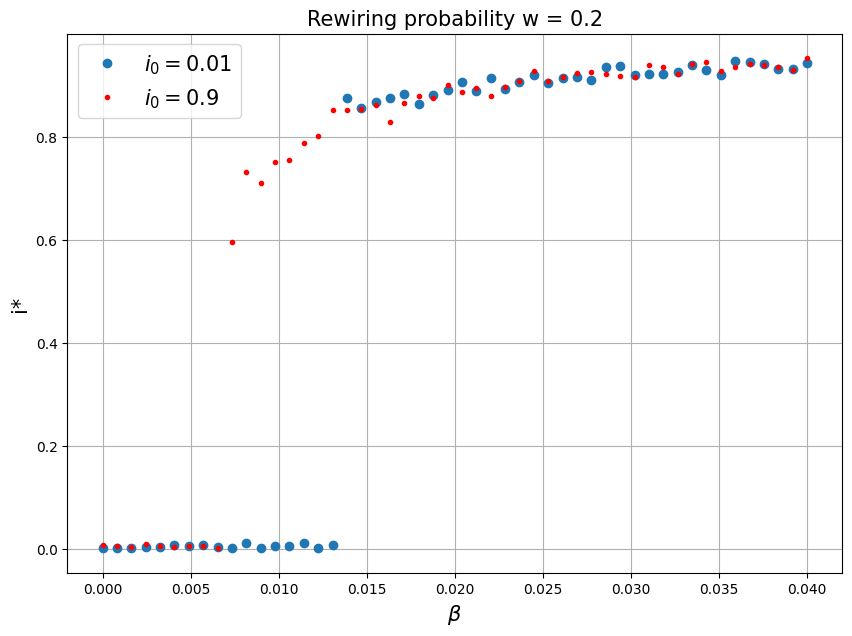

  0%|          | 0/50 [00:00<?, ?it/s]

Fraction of infected nodes:  0.003 ; Initial infected nodes:  10 ; Number of iterations:  51


  2%|▏         | 1/50 [00:06<05:41,  6.97s/it]

Fraction of infected nodes:  0.01 ; Initial infected nodes:  900 ; Number of iterations:  238
Fraction of infected nodes:  0.005 ; Initial infected nodes:  10 ; Number of iterations:  51


  4%|▍         | 2/50 [00:14<05:43,  7.16s/it]

Fraction of infected nodes:  0.006 ; Initial infected nodes:  900 ; Number of iterations:  256
Fraction of infected nodes:  0.004 ; Initial infected nodes:  10 ; Number of iterations:  51


  6%|▌         | 3/50 [00:21<05:35,  7.14s/it]

Fraction of infected nodes:  0.004 ; Initial infected nodes:  900 ; Number of iterations:  238
Fraction of infected nodes:  0.005 ; Initial infected nodes:  10 ; Number of iterations:  51


  8%|▊         | 4/50 [00:28<05:31,  7.20s/it]

Fraction of infected nodes:  0.008 ; Initial infected nodes:  900 ; Number of iterations:  245
Fraction of infected nodes:  0.004 ; Initial infected nodes:  10 ; Number of iterations:  51


 10%|█         | 5/50 [00:35<05:24,  7.22s/it]

Fraction of infected nodes:  0.005 ; Initial infected nodes:  900 ; Number of iterations:  252
Fraction of infected nodes:  0.002 ; Initial infected nodes:  10 ; Number of iterations:  51


 12%|█▏        | 6/50 [00:43<05:20,  7.30s/it]

Fraction of infected nodes:  0.006 ; Initial infected nodes:  900 ; Number of iterations:  262
Fraction of infected nodes:  0.004 ; Initial infected nodes:  10 ; Number of iterations:  51


 14%|█▍        | 7/50 [00:51<05:20,  7.46s/it]

Fraction of infected nodes:  0.005 ; Initial infected nodes:  900 ; Number of iterations:  273
Fraction of infected nodes:  0.005 ; Initial infected nodes:  10 ; Number of iterations:  51


 16%|█▌        | 8/50 [00:58<05:15,  7.51s/it]

Fraction of infected nodes:  0.003 ; Initial infected nodes:  900 ; Number of iterations:  259
Fraction of infected nodes:  0.005 ; Initial infected nodes:  10 ; Number of iterations:  51


 18%|█▊        | 9/50 [01:06<05:08,  7.52s/it]

Fraction of infected nodes:  0.004 ; Initial infected nodes:  900 ; Number of iterations:  249
Fraction of infected nodes:  0.003 ; Initial infected nodes:  10 ; Number of iterations:  51


 20%|██        | 10/50 [01:14<05:07,  7.69s/it]

Fraction of infected nodes:  0.004 ; Initial infected nodes:  900 ; Number of iterations:  273
Fraction of infected nodes:  0.006 ; Initial infected nodes:  10 ; Number of iterations:  51


 22%|██▏       | 11/50 [01:22<05:02,  7.75s/it]

Fraction of infected nodes:  0.009 ; Initial infected nodes:  900 ; Number of iterations:  242
Fraction of infected nodes:  0.005 ; Initial infected nodes:  10 ; Number of iterations:  51


 24%|██▍       | 12/50 [01:30<04:55,  7.77s/it]

Fraction of infected nodes:  0.007 ; Initial infected nodes:  900 ; Number of iterations:  244
Fraction of infected nodes:  0.004 ; Initial infected nodes:  10 ; Number of iterations:  51


 26%|██▌       | 13/50 [01:38<04:51,  7.89s/it]

Fraction of infected nodes:  0.011 ; Initial infected nodes:  900 ; Number of iterations:  269
Fraction of infected nodes:  0.003 ; Initial infected nodes:  10 ; Number of iterations:  51


 28%|██▊       | 14/50 [01:46<04:51,  8.11s/it]

Fraction of infected nodes:  0.001 ; Initial infected nodes:  900 ; Number of iterations:  276
Fraction of infected nodes:  0.002 ; Initial infected nodes:  10 ; Number of iterations:  51


 30%|███       | 15/50 [01:55<04:45,  8.15s/it]

Fraction of infected nodes:  0.006 ; Initial infected nodes:  900 ; Number of iterations:  271
Fraction of infected nodes:  0.004 ; Initial infected nodes:  10 ; Number of iterations:  51


 32%|███▏      | 16/50 [02:04<04:44,  8.37s/it]

Fraction of infected nodes:  0.011 ; Initial infected nodes:  900 ; Number of iterations:  254
Fraction of infected nodes:  0.004 ; Initial infected nodes:  10 ; Number of iterations:  51


 34%|███▍      | 17/50 [02:14<04:57,  9.02s/it]

Fraction of infected nodes:  0.005 ; Initial infected nodes:  900 ; Number of iterations:  279
Fraction of infected nodes:  0.004 ; Initial infected nodes:  10 ; Number of iterations:  51


 36%|███▌      | 18/50 [02:23<04:43,  8.87s/it]

Fraction of infected nodes:  0.006 ; Initial infected nodes:  900 ; Number of iterations:  282
Fraction of infected nodes:  0.001 ; Initial infected nodes:  10 ; Number of iterations:  69


 38%|███▊      | 19/50 [02:31<04:31,  8.76s/it]

Fraction of infected nodes:  0.004 ; Initial infected nodes:  900 ; Number of iterations:  270
Fraction of infected nodes:  0.002 ; Initial infected nodes:  10 ; Number of iterations:  51


 40%|████      | 20/50 [02:40<04:27,  8.91s/it]

Fraction of infected nodes:  0.009 ; Initial infected nodes:  900 ; Number of iterations:  240
Fraction of infected nodes:  0.005 ; Initial infected nodes:  10 ; Number of iterations:  51


 42%|████▏     | 21/50 [02:50<04:23,  9.09s/it]

Fraction of infected nodes:  0.01 ; Initial infected nodes:  900 ; Number of iterations:  239
Fraction of infected nodes:  0.007 ; Initial infected nodes:  10 ; Number of iterations:  51


 44%|████▍     | 22/50 [03:01<04:29,  9.62s/it]

Fraction of infected nodes:  0.005 ; Initial infected nodes:  900 ; Number of iterations:  267
Fraction of infected nodes:  0.007 ; Initial infected nodes:  10 ; Number of iterations:  51


 46%|████▌     | 23/50 [03:16<05:08, 11.44s/it]

Fraction of infected nodes:  0.003 ; Initial infected nodes:  900 ; Number of iterations:  277
Fraction of infected nodes:  0.007 ; Initial infected nodes:  10 ; Number of iterations:  51


 48%|████▊     | 24/50 [03:29<05:06, 11.78s/it]

Fraction of infected nodes:  0.009 ; Initial infected nodes:  900 ; Number of iterations:  257
Fraction of infected nodes:  0.002 ; Initial infected nodes:  10 ; Number of iterations:  51


 50%|█████     | 25/50 [03:54<06:36, 15.88s/it]

Fraction of infected nodes:  0.01 ; Initial infected nodes:  900 ; Number of iterations:  281
Fraction of infected nodes:  0.007 ; Initial infected nodes:  10 ; Number of iterations:  61


 52%|█████▏    | 26/50 [05:17<14:19, 35.82s/it]

Fraction of infected nodes:  0.007 ; Initial infected nodes:  900 ; Number of iterations:  391
Fraction of infected nodes:  0.005 ; Initial infected nodes:  10 ; Number of iterations:  51


 54%|█████▍    | 27/50 [07:02<21:41, 56.57s/it]

Fraction of infected nodes:  0.003 ; Initial infected nodes:  900 ; Number of iterations:  465
Fraction of infected nodes:  0.002 ; Initial infected nodes:  10 ; Number of iterations:  51


 56%|█████▌    | 28/50 [08:22<23:24, 63.83s/it]

Fraction of infected nodes:  0.005 ; Initial infected nodes:  900 ; Number of iterations:  407
Fraction of infected nodes:  0.004 ; Initial infected nodes:  10 ; Number of iterations:  58


 58%|█████▊    | 29/50 [09:28<22:29, 64.27s/it]

Fraction of infected nodes:  0.006 ; Initial infected nodes:  900 ; Number of iterations:  411
Fraction of infected nodes:  0.005 ; Initial infected nodes:  10 ; Number of iterations:  51


 60%|██████    | 30/50 [10:16<19:47, 59.36s/it]

Fraction of infected nodes:  0.009 ; Initial infected nodes:  900 ; Number of iterations:  337
Fraction of infected nodes:  0.002 ; Initial infected nodes:  10 ; Number of iterations:  51


 62%|██████▏   | 31/50 [11:33<20:29, 64.73s/it]

Fraction of infected nodes:  0.006 ; Initial infected nodes:  900 ; Number of iterations:  468
Fraction of infected nodes:  0.004 ; Initial infected nodes:  10 ; Number of iterations:  51


 64%|██████▍   | 32/50 [12:30<18:42, 62.35s/it]

Fraction of infected nodes:  0.007 ; Initial infected nodes:  900 ; Number of iterations:  366
Fraction of infected nodes:  0.007 ; Initial infected nodes:  10 ; Number of iterations:  84


 66%|██████▌   | 33/50 [14:08<20:42, 73.07s/it]

Fraction of infected nodes:  0.005 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.003 ; Initial infected nodes:  10 ; Number of iterations:  51


 68%|██████▊   | 34/50 [15:30<20:11, 75.74s/it]

Fraction of infected nodes:  0.008 ; Initial infected nodes:  900 ; Number of iterations:  484
Fraction of infected nodes:  0.007 ; Initial infected nodes:  10 ; Number of iterations:  51


 70%|███████   | 35/50 [17:01<20:04, 80.32s/it]

Fraction of infected nodes:  0.01 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.004 ; Initial infected nodes:  10 ; Number of iterations:  88


 72%|███████▏  | 36/50 [18:17<18:28, 79.21s/it]

Fraction of infected nodes:  0.004 ; Initial infected nodes:  900 ; Number of iterations:  481
Fraction of infected nodes:  0.0 ; Initial infected nodes:  10 ; Number of iterations:  75


 74%|███████▍  | 37/50 [19:31<16:48, 77.60s/it]

Fraction of infected nodes:  0.006 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.005 ; Initial infected nodes:  10 ; Number of iterations:  51


 76%|███████▌  | 38/50 [20:33<14:35, 72.92s/it]

Fraction of infected nodes:  0.006 ; Initial infected nodes:  900 ; Number of iterations:  457
Fraction of infected nodes:  0.014 ; Initial infected nodes:  10 ; Number of iterations:  79


 78%|███████▊  | 39/50 [22:06<14:27, 78.89s/it]

Fraction of infected nodes:  0.021 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.004 ; Initial infected nodes:  10 ; Number of iterations:  72


 80%|████████  | 40/50 [23:18<12:46, 76.68s/it]

Fraction of infected nodes:  0.011 ; Initial infected nodes:  900 ; Number of iterations:  482
Fraction of infected nodes:  0.005 ; Initial infected nodes:  10 ; Number of iterations:  62


 82%|████████▏ | 41/50 [24:40<11:46, 78.47s/it]

Fraction of infected nodes:  0.021 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.011 ; Initial infected nodes:  10 ; Number of iterations:  51


 84%|████████▍ | 42/50 [26:27<11:35, 86.95s/it]

Fraction of infected nodes:  0.173 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.011 ; Initial infected nodes:  10 ; Number of iterations:  51


 86%|████████▌ | 43/50 [27:27<09:12, 78.88s/it]

Fraction of infected nodes:  0.006 ; Initial infected nodes:  900 ; Number of iterations:  479
Fraction of infected nodes:  0.004 ; Initial infected nodes:  10 ; Number of iterations:  73


 88%|████████▊ | 44/50 [29:04<08:26, 84.44s/it]

Fraction of infected nodes:  0.079 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.011 ; Initial infected nodes:  10 ; Number of iterations:  60


 90%|█████████ | 45/50 [30:40<07:18, 87.73s/it]

Fraction of infected nodes:  0.17 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.011 ; Initial infected nodes:  10 ; Number of iterations:  81


 92%|█████████▏| 46/50 [31:57<05:38, 84.69s/it]

Fraction of infected nodes:  0.037 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.005 ; Initial infected nodes:  10 ; Number of iterations:  56


 94%|█████████▍| 47/50 [33:06<03:59, 79.80s/it]

Fraction of infected nodes:  0.029 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.005 ; Initial infected nodes:  10 ; Number of iterations:  77


 96%|█████████▌| 48/50 [34:18<02:34, 77.48s/it]

Fraction of infected nodes:  0.049 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.01 ; Initial infected nodes:  10 ; Number of iterations:  98


 98%|█████████▊| 49/50 [35:50<01:21, 81.88s/it]

Fraction of infected nodes:  0.328 ; Initial infected nodes:  900 ; Number of iterations:  499
Fraction of infected nodes:  0.009 ; Initial infected nodes:  10 ; Number of iterations:  81


100%|██████████| 50/50 [37:18<00:00, 44.76s/it]

Fraction of infected nodes:  0.25 ; Initial infected nodes:  900 ; Number of iterations:  499


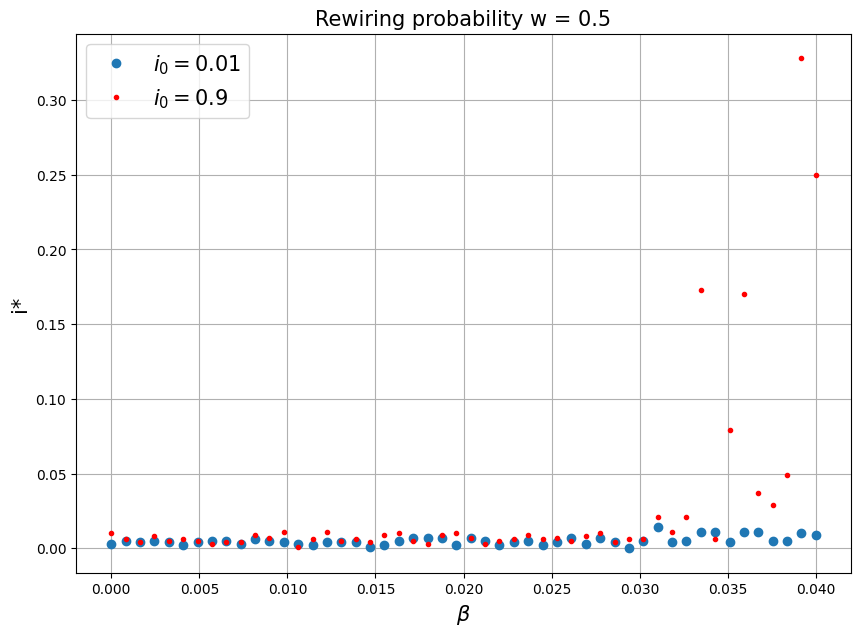

In [5]:
# network
G = nx.erdos_renyi_graph(N, p)
# simulation parameters
n_iter = 500
tol = 1e-5
for w in w_list:
    make_numerical_graph(G, mu, beta_list, w, m_low, m_high, n_iter, tol)